In [16]:
#import libraries
import math
from scipy import signal
from PIL import Image
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from pylab import *
import cv2

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Reading images

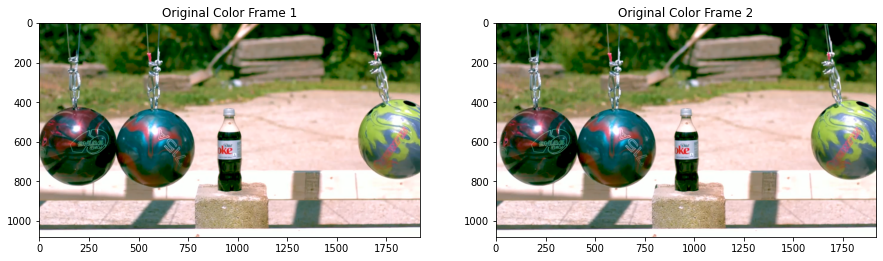

In [18]:
Image1_path = 'img3.jpg'
Image2_path = 'img4.jpg'
Image1_Color = Image.open(Image1_path)
Image2_Color = Image.open(Image2_path)
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.title('Original Color Frame 1')
plt.imshow(Image1_Color)
plt.subplot(1,2,2)
plt.title('Original Color Frame 2')
plt.imshow(Image2_Color)

## 1. Choose two consecutive images from a video sequence. Convert images to grayscale.

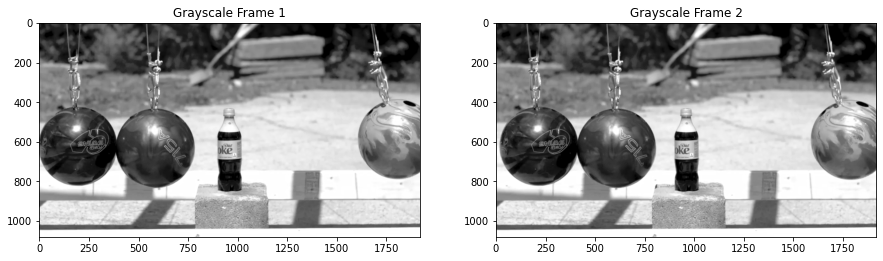

In [19]:
Image1 = Image1_Color.convert("L")
Image2 = Image2_Color.convert("L")
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.title('Grayscale Frame 1')
plt.imshow(Image1, cmap='gray')
plt.subplot(1,2,2)
plt.title('Grayscale Frame 2')
plt.imshow(Image2, cmap='gray')

## 2. Gaussian Filtering on the frames

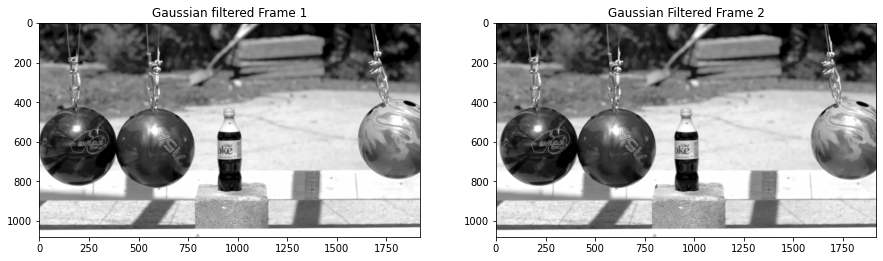

In [20]:
I1 = np.array(Image1) # Converting image 1 to numpy array
I2 = np.array(Image2) # Converting image 2 to numpy array
S = np.shape(I1)

#applying Gaussian filter of size 3x3 to eliminate any noise
I1_smooth = cv2.GaussianBlur(I1 ,(3,3), 0) # Applying Gaussian filter over the image 1
I2_smooth = cv2.GaussianBlur(I2, (3,3), 0) # Applying Gaussian filter over the image 2

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.title('Gaussian filtered Frame 1')
plt.imshow(I1_smooth, cmap='gray')
plt.subplot(1,2,2)
plt.title('Gaussian Filtered Frame 2')
plt.imshow(I2_smooth, cmap='gray')

## 3. Calculate the spatial derivatives Ex = ∂E/∂x and Ey = ∂E/∂y

### Calculating spatial derivative along X, Y and time gradient

In [21]:
# First Derivative in X direction
Ix = signal.convolve2d(
    I1_smooth,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,0.25],[-0.25,0.25]],'same')

# First Derivative in Y direction
Iy = signal.convolve2d(
    I1_smooth,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,-0.25],[0.25,0.25]],'same')

## 4. Calculate the time gradient by the difference between consecutive frames, simply subtracting the two frames as Et=I(x, y, t + 1) − I(x, y, t).

In [22]:
# Time Gradient
It = signal.convolve2d(
    I1_smooth,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,-0.25],[-0.25,-0.25]],'same')

## 5. Display the original image and the spatial and time gradients.

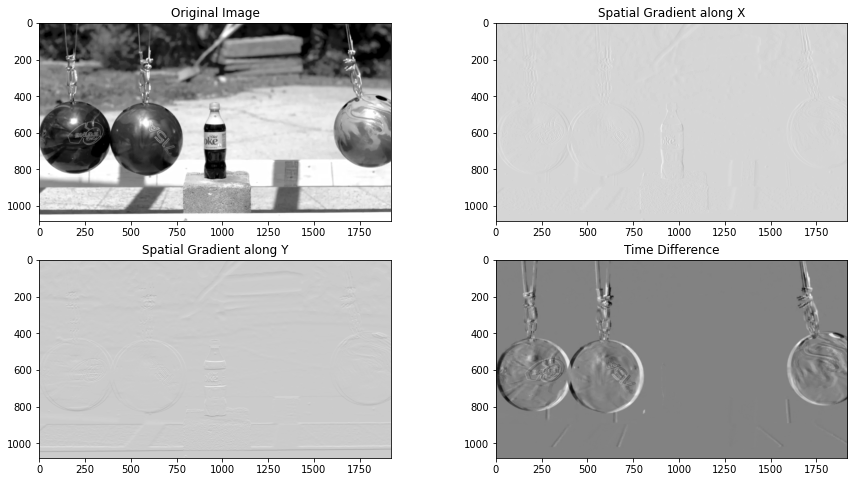

In [23]:
plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.title('Original Image')
plt.imshow(I1_smooth, cmap='gray')
plt.subplot(2,2,2)
plt.title('Spatial Gradient along X')
plt.imshow(Ix, cmap='gray')
plt.subplot(2,2,3)
plt.title('Spatial Gradient along Y')
plt.imshow(Iy, cmap='gray')
plt.subplot(2,2,4)
plt.title('Time Difference')
plt.imshow(It, cmap='gray')

#### Will be choosing 10K features from the image using the good features to track function from OpenCV

If we use all the features from the image to do the computation, it took so much time(and was highly computational as the image size increased) thus selecting the signigicantly important feature from the image was the decision made to do the optical flow computation

In [24]:
# finding the good features
features = cv2.goodFeaturesToTrack(I1_smooth, 10000, 0.01,10) 
feature = np.int0(features)

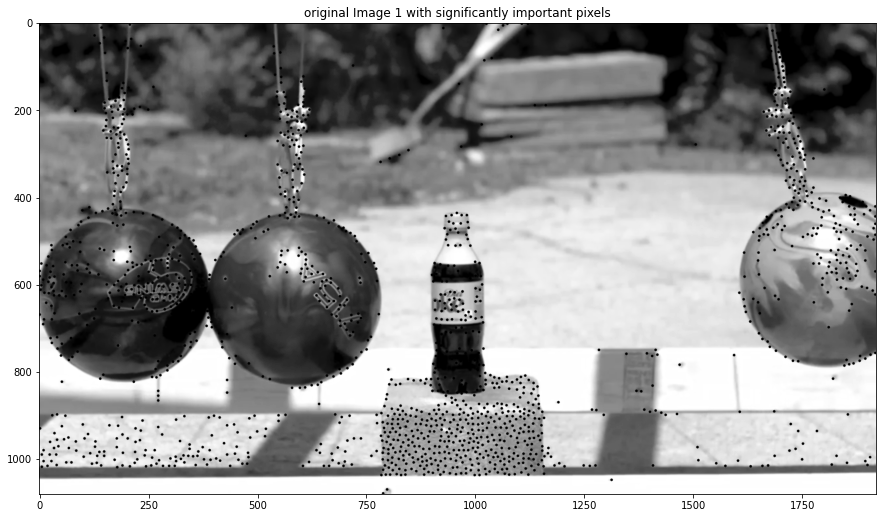

In [26]:
plt.figure(figsize=(15,15))
plt.title("original Image 1 with significantly important pixels")
plt.imshow(I1_smooth, cmap = cm.gray)
for i in feature:
    x,y = i.ravel()
    cv2.circle(I1_smooth, (x,y), 3, 0, -1)

As seen from the above figure, the dots represents the significantly important feature

## 6. Compute the flow vectors u and v. To compute these parameters, you need to select a neighborhood size and then solve the optical flow equation using points in the neighborhood.

In [27]:
#creating the u and v vector
u, v = np.nan*np.ones(S), np.nan*np.ones(S)

# Calculating the u and v arrays for the good features obtained n the previous step.
for l in feature:
    j,i = l.ravel()
    # calculating the derivatives for the neighbouring pixels
    # since we are using  a 3*3 window, we have 9 elements for each derivative.

    IX = (
        [
            Ix[i-1,j-1],
            Ix[i,j-1],
            Ix[i-1,j-1],
            Ix[i-1,j],
            Ix[i,j],
            Ix[i+1,j],
            Ix[i-1,j+1],
            Ix[i,j+1],
            Ix[i+1,j-1]
        ]
    ) #The x-component of the gradient vector
    IY = (
        [
            Iy[i-1,j-1],
            Iy[i,j-1],
            Iy[i-1,j-1],
            Iy[i-1,j],
            Iy[i,j],
            Iy[i+1,j],
            Iy[i-1,j+1],
            Iy[i,j+1],
            Iy[i+1,j-1]
        ]
    ) #The Y-component of the gradient vector
    IT = (
        [
            It[i-1,j-1],
            It[i,j-1],
            It[i-1,j-1],
            It[i-1,j],
            It[i,j],
            It[i+1,j],
            It[i-1,j+1],
            It[i,j+1],
            It[i+1,j-1]
        ]
    ) #The XY-component of the gradient vector

    # Using the minimum least squares solution approach
    LK = (IX, IY)
    LK = np.matrix(LK)
    LK_T = np.array(np.matrix(LK)) # transpose of A
    LK = np.array(np.matrix.transpose(LK)) 

    A1 = np.dot(LK_T,LK) #Psedudo Inverse
    A2 = np.linalg.pinv(A1)
    A3 = np.dot(A2,LK_T)

    (u[i,j],v[i,j]) = np.dot(A3,IT) # we have the vectors with minimized square error

## 7. Display the computed flow vectors over the original image.

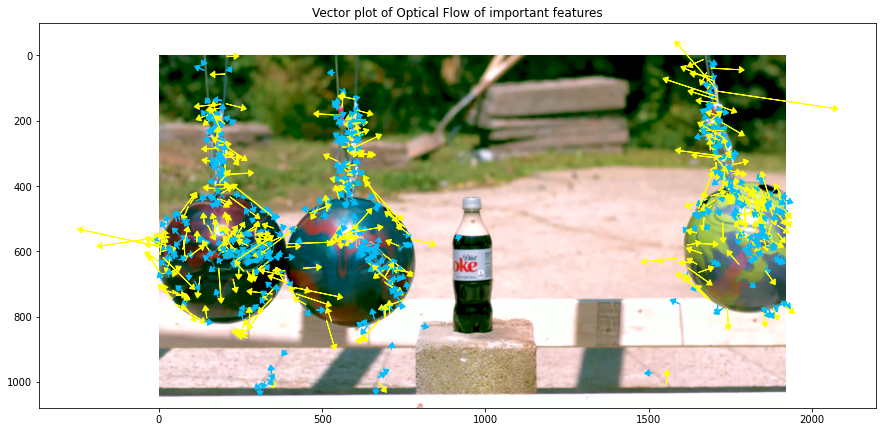

In [28]:
t = 2 # threshold for plotting vector, if the vector is smaller than this, then don't display
large_t = 10
plt.figure(figsize=(15,15))
plt.title('Vector plot of Optical Flow of important features')
plt.imshow(Image1_Color, cmap = cm.gray)
for i in range(S[0]):
    for j in range(S[1]):
        if abs(u[i,j]) > large_t or abs(v[i,j]) > large_t: # setting the threshold to plot the vector
            plt.arrow(j, i, 1.75*v[i,j],1.75*u[i,j], head_width = 20, head_length = 15, color = "yellow")
        
        elif abs(u[i,j]) > t or abs(v[i,j]) > t: # setting the threshold to plot the vectors
            plt.arrow(j, i, 1.75*v[i,j], 1.75*u[i,j], head_width = 20, head_length = 15, color = "deepskyblue")
        